In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
import efficientnet.keras as efn
import tensorflow as tf
import keras.backend as K
from keras.legacy import interfaces
from keras.optimizers import Optimizer
import runai.ga
from keras_gradient_accumulation import GradientAccumulation
import keras
import datetime
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
waste_types = ['cardboard','glass','metal','paper','plastic','trash']
nb_classes = len(waste_types)
dataset_name = 'Trashnet'

In [3]:
from PIL import Image
import glob
def verify_dataset_images(dataset_name, waste_types): 
    subsets = ['train','valid']
    for subset in subsets:
        for waste_type in waste_types:
            waste_images = glob.glob(f'{dataset_name}/{subset}/{waste_type}/*')
            for image in waste_images:
                try:
                    Image.open(image)
                except:
                    print ("Error in ", image)
                    #os.remove(image)
                    
verify_dataset_images(dataset_name, waste_types)


In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = np.round(cm,2).astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(f'{title}.jpg')
    plt.show()

In [4]:
B0_PW_weights = "models-B0\model-B0-loss.hdf5"
B1_PW_weights = "models-B1\model-B0-loss.hdf5"
B2_PW_weights = "models-B2-PW\model-B2-PW-loss.hdf5"
B3_PW_weights = "models-B3-PW\model-B3-PW-loss.hdf5"
B4_PW_weights = "models-B4-PW\model-B4-PW-loss.hdf5"
B5_PW_weights = "models-B5-PW\model-B5-PW-loss.hdf5"
B6_PW_weights = "models-B6-PW\model-B6-PW-loss.hdf5"
B7_PW_weights = "models-B7-PW\model-B7-PW-loss.hdf5"
B0_weights = "models-B0\model-B0-loss.hdf5"
B1_weights = "models-B1\model-B1-loss.hdf5"
B2_weights = "models-B2\model-B2-loss.hdf5"
B3_weights = "models-B3\model-B3-loss.hdf5"
B4_weights = "models-B4\model-B4-loss.hdf5"
B5_weights = "models-B5\model-B5-loss.hdf5"
B6_weights = "models-B6\model-B6-loss.hdf5"
B7_weights = "models-B7\model-B7-loss.hdf5"

In [5]:
def get_gradient_accumulation_steps(batch_size_actual,batch_size_required):
    return int(batch_size_required/batch_size_actual)

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
def initialize_vars(batch = 8, images_size = 224, data_folder = "data"):
    batch_size = batch
    img_size = images_size 
    
    train_datagen=ImageDataGenerator(rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2
    )
    train_generator = train_datagen.flow_from_directory(
    f'{data_folder}',
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size),
    subset='training')

    #test_datagen = ImageDataGenerator(rescale=1./255)
    valid_generator=train_datagen.flow_from_directory(
    f'{data_folder}',
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",    
    target_size=(img_size,img_size),
    subset='validation')
    
    return batch_size, img_size, train_generator, valid_generator

def get_model(modelType, weights = None, learning_rate = 0.0001):
    base_model = modelType

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(7, activation='softmax'))
    
    optimizer = runai.ga.keras.optimizers.RMSprop(lr=learning_rate, steps = get_gradient_accumulation_steps(batch_size,16))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', f1_m])
    
    if weights != None:
        model.load_weights(weights)
    
    model.pop()
    model.add(Dense(6, activation='softmax'))
    optimizer = runai.ga.keras.optimizers.RMSprop(lr=learning_rate, steps = get_gradient_accumulation_steps(batch_size,16))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', f1_m])

    
    return model

def set_model_path(model_name, pretrained_weights = ""):
    if pretrained_weights != "":
        model_name = model_name+"-PW"
        
    model_path = f'trashnet-models-{model_name}/'
    if not os.path.exists(model_path):
        os.mkdir(model_path)
    original_model_path = model_path + 'trashnet-model-'+model_name+'.hdf5'
    loss_model_path = model_path + 'trashnet-model-'+model_name+'-loss.hdf5'
    acc_model_path = model_path + 'trashnet-model-'+model_name+'-acc.hdf5'
    return original_model_path, loss_model_path, acc_model_path

def select_model(model_name, img_size, pretrained=False):
    if model_name=="B0":
        model = efn.EfficientNetB0(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B0_weights
        else:
            weights = B0_PW_weights
    elif model_name=="B1":
        model = efn.EfficientNetB1(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B1_weights
        else:
            weights = B1_PW_weights
    elif model_name=="B2":
        model = efn.EfficientNetB2(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B2_weights
        else:
            weights = B2_PW_weights
    elif model_name=="B3":
        model = efn.EfficientNetB3(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B3_weights
        else:
            weights = B3_PW_weights
    elif model_name=="B4":
        model = efn.EfficientNetB4(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B4_weights
        else:
            weights = B4_PW_weights
    elif model_name=="B5":
        model = efn.EfficientNetB5(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B5_weights
        else:
            weights = B5_PW_weights
    elif model_name=="B6":
        model = efn.EfficientNetB6(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B6_weights
        else:
            weights = B6_PW_weights
    elif model_name=="B7":
        model = efn.EfficientNetB7(include_top=False, input_shape=(img_size, img_size, 3))
        if pretrained==False:
            weights = B7_weights
        else:
            weights = B7_PW_weights
    if pretrained == True:
        model_path, loss_model_path, acc_model_path = set_model_path(model_name, True)
    else:
        model_path, loss_model_path, acc_model_path = set_model_path(model_name)
    return model, weights, model_path, loss_model_path, acc_model_path

def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size
def get_callbacks(loss_model_path,acc_model_path, patience = 10, min_lr = 0.00001, patience_dividing_factor = 2):
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

    patient = patience
    callbacks = [
        EarlyStopping(monitor='val_acc', patience=patient, mode='max', verbose=1),
        ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = int(patient / patience_dividing_factor), min_lr=min_lr, verbose=1, mode='min'),
        ModelCheckpoint(filepath=loss_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
        ModelCheckpoint(filepath=acc_model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
        tensorboard_callback
        ]
    return callbacks
def plot_graph(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Traing loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Trainging and validation loss')
    plt.legend()
    plt.show()
def get_results(model, generator):
    
    #model.load_weights(acc_model_path)
    Y_pred = model.predict_generator(valid_generator, 
                                 len(valid_generator.classes)//batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(valid_generator.classes, y_pred)
    disp = plot_confusion_matrix(cm,target_names = ['cardboard','glass','metal',
                                      'paper','plastic','trash'])
    target_names = ['cardboard','glass','metal','paper','plastic','trash']
    print(classification_report(valid_generator.classes, y_pred, target_names=target_names))
    print ("Accuracy-",accuracy_score(valid_generator.classes, y_pred))

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [19-06-2020 22:33:22.798] [25928] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps
[Run:AI] [DEBUG   ] [19-06-2020 22:33:24.458] [25928] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps





Epoch 1/100
127/127 [==============================] - 59s 462ms/step - loss: 0.7751 - acc: 0.7302 - f1_m: 0.6988 - val_loss: 0.7036 - val_acc: 0.9384 - val_f1_m: 0.9211

Epoch 00001: val_loss improved from inf to 0.70356, saving model to trashnet-models-B0/trashnet-model-B0-loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.93837, saving model to trashnet-models-B0/trashnet-model-B0-acc.hdf5

Epoch 2/100
127/127 [==============================] - 29s 226ms/step - loss: 0.3050 - acc: 0.9022 - f1_m: 0.8977 - val_loss: 0.1276 - val_acc: 0.9443 - val_f1_m: 0.9427

Epoch 00002: val_loss improved from 0.70356 to 0.12760, saving model to trashnet-models-B0/trashnet-model-B0-loss.hdf5

Epoch 00002: val_acc improved from 0.93837 to 0.94433, saving model to trashnet-models-B0/trashnet-model-B0-acc.hdf5
Epoch 3/100
127/127 [==============================] - 32s 255ms/step - loss: 0.2354 - acc: 0.9170 - f1_m: 0.9191 - val_loss: 1.6806 - val_acc: 0.9423 - val_f1_m: 0.9306

Epoch 00003: val

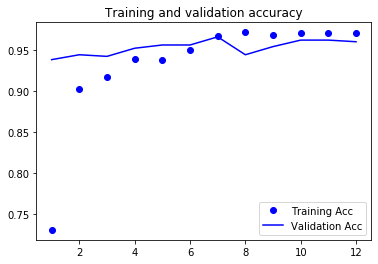

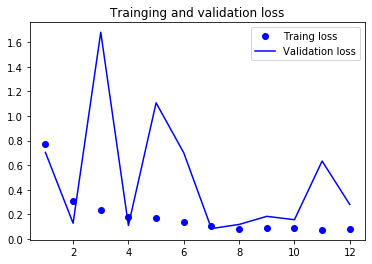

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Trashnet//valid'

In [8]:
data_folder = 'Trashnet'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = data_folder)
model, weights, model_path, loss_model_path, acc_model_path = select_model("B0", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, valid_generator)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

In [ ]:
get_results(model, valid_generator)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [19-06-2020 22:48:19.194] [18372] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps
[Run:AI] [DEBUG   ] [19-06-2020 22:48:21.981] [18372] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps





Epoch 1/100
127/127 [==============================] - 82s 646ms/step - loss: 0.5247 - acc: 0.8197 - f1_m: 0.8027 - val_loss: 0.1659 - val_acc: 0.9801 - val_f1_m: 0.9803

Epoch 00001: val_loss improved from inf to 0.16585, saving model to trashnet-models-B3/trashnet-model-B3-loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.98012, saving model to trashnet-models-B3/trashnet-model-B3-acc.hdf5

Epoch 2/100
127/127 [==============================] - 52s 407ms/step - loss: 0.2109 - acc: 0.9343 - f1_m: 0.9355 - val_loss: 0.1492 - val_acc: 0.9682 - val_f1_m: 0.9686

Epoch 00002: val_loss improved from 0.16585 to 0.14921, saving model to trashnet-models-B3/trashnet-model-B3-loss.hdf5

Epoch 00002: val_acc did not improve from 0.98012
Epoch 3/100
127/127 [==============================] - 50s 397ms/step - loss: 0.1280 - acc: 0.9560 - f1_m: 0.9579 - val_loss: 0.0992 - val_acc: 0.9801 - val_f1_m: 0.9805

Epoch 00003: val_loss improved from 0.14921 to 0.09916, saving model to trashnet-mo

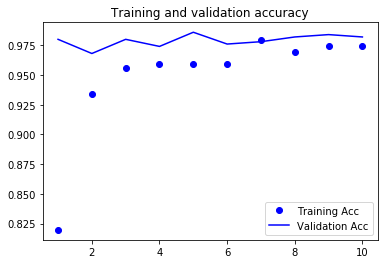

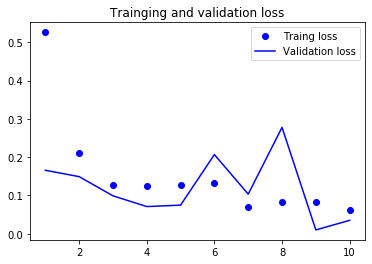

Confusion Matrix


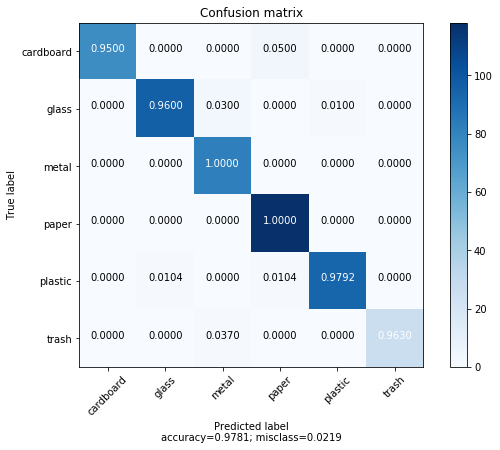

              precision    recall  f1-score   support

   cardboard       1.00      0.95      0.97        80
       glass       0.99      0.96      0.97       100
       metal       0.95      1.00      0.98        82
       paper       0.96      1.00      0.98       118
     plastic       0.99      0.98      0.98        96
       trash       1.00      0.96      0.98        27

    accuracy                           0.98       503
   macro avg       0.98      0.98      0.98       503
weighted avg       0.98      0.98      0.98       503

Accuracy- 0.9781312127236581
trashnet-models-B3/trashnet-model-B3.hdf5
trashnet-models-B3/trashnet-model-B3-loss.hdf5
trashnet-models-B3/trashnet-model-B3-acc.hdf5


In [8]:
data_folder = 'Trashnet'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = data_folder)
model, weights, model_path, loss_model_path, acc_model_path = select_model("B3", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, valid_generator)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


[Run:AI] [DEBUG   ] [19-06-2020 22:58:41.585] [18372] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps
[Run:AI] [DEBUG   ] [19-06-2020 22:58:46.736] [18372] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Epoch 1/100
127/127 [==============================] - 61s 479ms/step - loss: 0.6736 - acc: 0.7609 - f1_m: 0.7409 - val_loss: 1.0170 - val_acc: 0.9404 - val_f1_m: 0.9365

Epoch 00001: val_loss improved from inf to 1.01700, saving model to trashnet-models-B1/trashnet-model-B1-loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.94036, saving model to trashnet-models-B1/trashnet-model-B1-acc.hdf5
Epoch 2/100
127/127 [==============================] - 40s 316ms/step - loss: 0.3614 - acc: 0.8745 - f1_m: 0.8714 - val_loss: 1.0727 - val_acc: 0.9304 - val_f1_m: 0.9265

Epoch 00002: val_loss did not improve from 1.01700

Epoch 00002: val_acc did not improve from 0.94036
Epoch 3/100
127/127 [==============================] - 40s 315ms/step - loss: 0.2480 - acc: 0.9086 - f1_m: 0.9086 - val_loss: 0.7919 - val_acc: 0.9483 - val_f1_m: 0.9425

Epoch 00003: val_loss improved from 1.01700 to 0.79191, saving model to trashnet-models-B1/trashnet-model-B1-loss.hdf5

Epoch 00003: val_acc improved from 

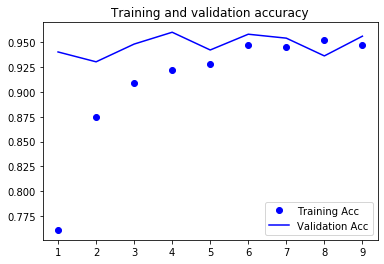

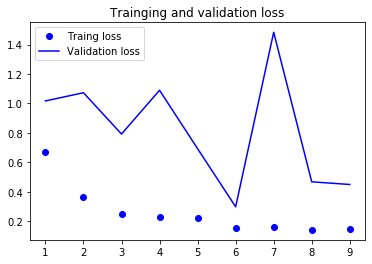

Confusion Matrix


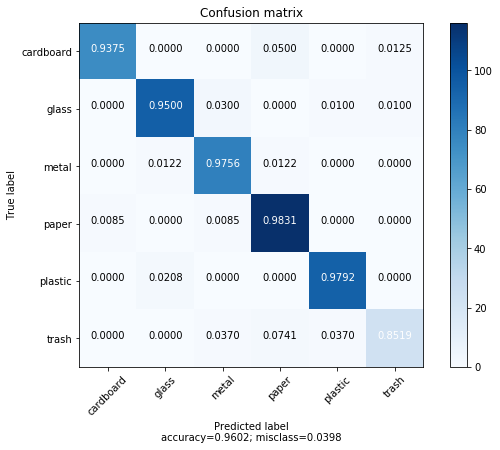

              precision    recall  f1-score   support

   cardboard       0.99      0.94      0.96        80
       glass       0.97      0.95      0.96       100
       metal       0.94      0.98      0.96        82
       paper       0.94      0.98      0.96       118
     plastic       0.98      0.98      0.98        96
       trash       0.92      0.85      0.88        27

    accuracy                           0.96       503
   macro avg       0.96      0.95      0.95       503
weighted avg       0.96      0.96      0.96       503

Accuracy- 0.9602385685884692
trashnet-models-B1/trashnet-model-B1.hdf5
trashnet-models-B1/trashnet-model-B1-loss.hdf5
trashnet-models-B1/trashnet-model-B1-acc.hdf5


In [9]:
data_folder = 'Trashnet'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = data_folder)
model, weights, model_path, loss_model_path, acc_model_path = select_model("B1", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, valid_generator)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


[Run:AI] [DEBUG   ] [19-06-2020 23:06:24.818] [18372] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps
[Run:AI] [DEBUG   ] [19-06-2020 23:06:33.771] [18372] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Epoch 1/100
127/127 [==============================] - 65s 513ms/step - loss: 0.6741 - acc: 0.7594 - f1_m: 0.7410 - val_loss: 0.1892 - val_acc: 0.9583 - val_f1_m: 0.9542

Epoch 00001: val_loss improved from inf to 0.18918, saving model to trashnet-models-B2/trashnet-model-B2-loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.95825, saving model to trashnet-models-B2/trashnet-model-B2-acc.hdf5
Epoch 2/100
127/127 [==============================] - 42s 331ms/step - loss: 0.2716 - acc: 0.9116 - f1_m: 0.9076 - val_loss: 0.0824 - val_acc: 0.9642 - val_f1_m: 0.9643

Epoch 00002: val_loss improved from 0.18918 to 0.08241, saving model to trashnet-models-B2/trashnet-model-B2-loss.hdf5

Epoch 00002: val_acc improved from 0.95825 to 0.96421, saving model to trashnet-models-B2/trashnet-model-B2-acc.hdf5
Epoch 3/100
127/127 [==============================] - 42s 331ms/step - loss: 0.1880 - acc: 0.9402 - f1_m: 0.9392 - val_loss: 0.1232 - val_acc: 0.9742 - val_f1_m: 0.9744

Epoch 00003: val_los

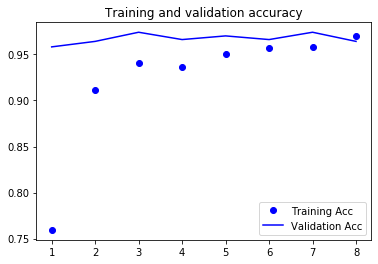

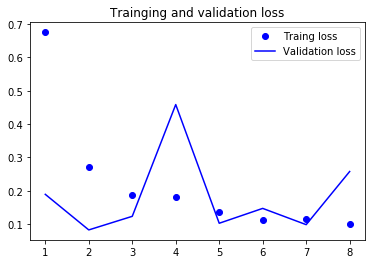

Confusion Matrix


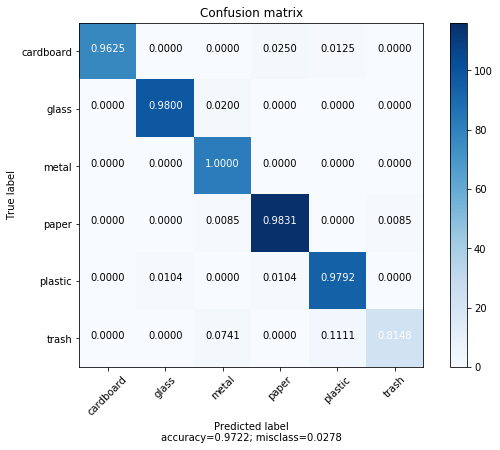

              precision    recall  f1-score   support

   cardboard       1.00      0.96      0.98        80
       glass       0.99      0.98      0.98       100
       metal       0.94      1.00      0.97        82
       paper       0.97      0.98      0.98       118
     plastic       0.96      0.98      0.97        96
       trash       0.96      0.81      0.88        27

    accuracy                           0.97       503
   macro avg       0.97      0.95      0.96       503
weighted avg       0.97      0.97      0.97       503

Accuracy- 0.9721669980119284
trashnet-models-B2/trashnet-model-B2.hdf5
trashnet-models-B2/trashnet-model-B2-loss.hdf5
trashnet-models-B2/trashnet-model-B2-acc.hdf5


In [10]:
data_folder = 'Trashnet'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = data_folder)
model, weights, model_path, loss_model_path, acc_model_path = select_model("B2", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, valid_generator)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


[Run:AI] [DEBUG   ] [19-06-2020 23:22:12.136] [18372] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 2 steps
[Run:AI] [DEBUG   ] [19-06-2020 23:22:31.019] [18372] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 2 steps


Epoch 1/100
253/253 [==============================] - 127s 502ms/step - loss: 0.7333 - acc: 0.7376 - f1_m: 0.7182 - val_loss: 1.5730 - val_acc: 0.9404 - val_f1_m: 0.9336

Epoch 00001: val_loss improved from inf to 1.57296, saving model to trashnet-models-B4/trashnet-model-B4-loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.94036, saving model to trashnet-models-B4/trashnet-model-B4-acc.hdf5
Epoch 2/100
253/253 [==============================] - 82s 325ms/step - loss: 0.4577 - acc: 0.8444 - f1_m: 0.8456 - val_loss: 0.7024 - val_acc: 0.9483 - val_f1_m: 0.9464

Epoch 00002: val_loss improved from 1.57296 to 0.70243, saving model to trashnet-models-B4/trashnet-model-B4-loss.hdf5

Epoch 00002: val_acc improved from 0.94036 to 0.94831, saving model to trashnet-models-B4/trashnet-model-B4-acc.hdf5
Epoch 3/100
253/253 [==============================] - 83s 327ms/step - loss: 0.3410 - acc: 0.8794 - f1_m: 0.8790 - val_loss: 1.3395 - val_acc: 0.9503 - val_f1_m: 0.9447

Epoch 00003: val_lo

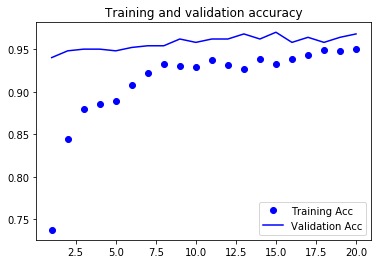

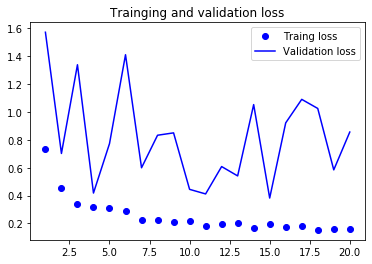

Confusion Matrix


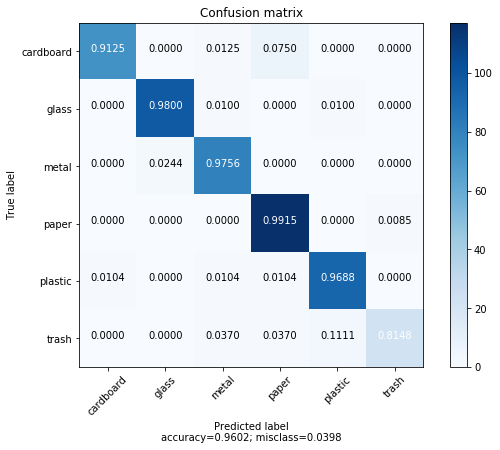

              precision    recall  f1-score   support

   cardboard       0.99      0.91      0.95        80
       glass       0.98      0.98      0.98       100
       metal       0.95      0.98      0.96        82
       paper       0.94      0.99      0.96       118
     plastic       0.96      0.97      0.96        96
       trash       0.96      0.81      0.88        27

    accuracy                           0.96       503
   macro avg       0.96      0.94      0.95       503
weighted avg       0.96      0.96      0.96       503

Accuracy- 0.9602385685884692
trashnet-models-B4/trashnet-model-B4.hdf5
trashnet-models-B4/trashnet-model-B4-loss.hdf5
trashnet-models-B4/trashnet-model-B4-acc.hdf5


In [11]:
data_folder = 'Trashnet'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 8, images_size = 224, data_folder = data_folder)
model, weights, model_path, loss_model_path, acc_model_path = select_model("B4", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, valid_generator)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

In [ ]:
data_folder = 'Trashnet'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = data_folder)
model, weights, model_path, loss_model_path, acc_model_path = select_model("B3", img_size, pretrained=False)
model = get_model(model, "trashnet-models-B3/trashnet-model-B3-loss.hdf5")
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, valid_generator)
print (model_path, loss_model_path, acc_model_path, sep = '\n')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [20-06-2020 00:05:44.704] [12868] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps
[Run:AI] [DEBUG   ] [20-06-2020 00:05:47.201] [12868] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps





Epoch 1/100
127/127 [==============================] - 72s 570ms/step - loss: 0.3824 - acc: 0.8681 - f1_m: 0.8596 - val_loss: 0.4554 - val_acc: 0.9662 - val_f1_m: 0.9642

Epoch 00001: val_loss improved from inf to 0.45535, saving model to trashnet-models-B3/trashnet-model-B3-loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.96620, saving model to trashnet-models-B3/trashnet-model-B3-acc.hdf5

Epoch 2/100
127/127 [==============================] - 50s 393ms/step - loss: 0.1139 - acc: 0.9620 - f1_m: 0.9626 - val_loss: 1.9604 - val_acc: 0.9563 - val_f1_m: 0.9452

Epoch 00002: val_loss did not improve from 0.45535

Epoch 00002: val_acc did not improve from 0.96620
Epoch 3/100
127/127 [==============================] - 54s 422ms/step - loss: 0.0955 - acc: 0.9718 - f1_m: 0.9702 - val_loss: 0.3810 - val_acc: 0.9682 - val_f1_m: 0.9673

Epoch 00003: val_loss improved from 0.45535 to 0.38105, saving model to trashnet-models-B3/trashnet-model-B3-loss.hdf5

Epoch 00003: val_acc improved f

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


[Run:AI] [DEBUG   ] [20-06-2020 13:19:50.752] [20676] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps
[Run:AI] [DEBUG   ] [20-06-2020 13:19:55.958] [20676] [optimizers.py          :16  ] Wrapping 'RMSprop' Keras optimizer with GA of 1 steps


Epoch 1/100
127/127 [==============================] - 75s 594ms/step - loss: 0.5996 - acc: 0.7777 - f1_m: 0.7613 - val_loss: 0.1188 - val_acc: 0.9642 - val_f1_m: 0.9675

Epoch 00001: val_loss improved from inf to 0.11876, saving model to trashnet-models-B3/trashnet-model-B3-loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.96421, saving model to trashnet-models-B3/trashnet-model-B3-acc.hdf5
Epoch 2/100
127/127 [==============================] - 51s 404ms/step - loss: 0.1884 - acc: 0.9373 - f1_m: 0.9378 - val_loss: 0.0538 - val_acc: 0.9841 - val_f1_m: 0.9851

Epoch 00002: val_loss improved from 0.11876 to 0.05384, saving model to trashnet-models-B3/trashnet-model-B3-loss.hdf5

Epoch 00002: val_acc improved from 0.96421 to 0.98410, saving model to trashnet-models-B3/trashnet-model-B3-acc.hdf5
Epoch 3/100
127/127 [==============================] - 52s 409ms/step - loss: 0.1436 - acc: 0.9545 - f1_m: 0.9538 - val_loss: 0.1495 - val_acc: 0.9761 - val_f1_m: 0.9754

Epoch 00003: val_los

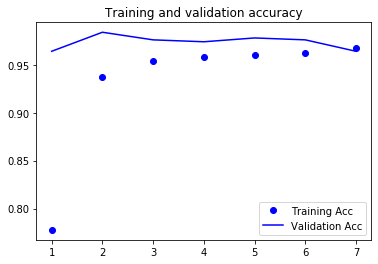

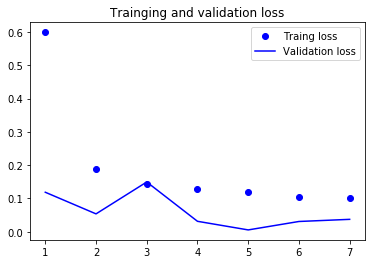

Confusion Matrix


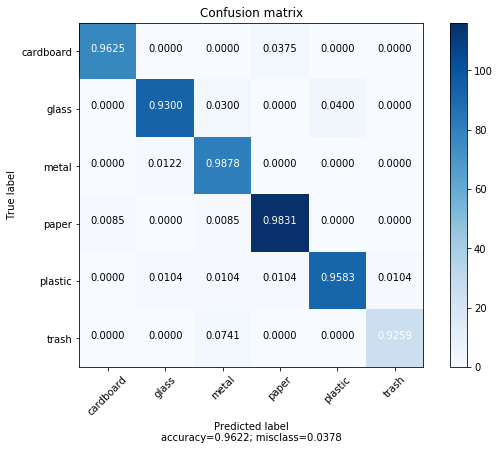

              precision    recall  f1-score   support

   cardboard       0.99      0.96      0.97        80
       glass       0.98      0.93      0.95       100
       metal       0.92      0.99      0.95        82
       paper       0.97      0.98      0.97       118
     plastic       0.96      0.96      0.96        96
       trash       0.96      0.93      0.94        27

    accuracy                           0.96       503
   macro avg       0.96      0.96      0.96       503
weighted avg       0.96      0.96      0.96       503

Accuracy- 0.9622266401590457
trashnet-models-B3/trashnet-model-B3.hdf5
trashnet-models-B3/trashnet-model-B3-loss.hdf5
trashnet-models-B3/trashnet-model-B3-acc.hdf5


In [8]:
data_folder = 'Trashnet'
batch_size, img_size, train_generator, valid_generator = initialize_vars(batch = 16, images_size = 224, data_folder = data_folder)
model, weights, model_path, loss_model_path, acc_model_path = select_model("B3", img_size, pretrained=False)
model = get_model(model, weights)
callbacks = get_callbacks(loss_model_path, acc_model_path, patience = 5, min_lr = 0.00001, patience_dividing_factor = 2)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(len(train_generator.filenames), batch_size),
    epochs=100,
    validation_data=valid_generator,
    validation_steps=get_steps(len(valid_generator.filenames), batch_size),
    verbose=1,
    callbacks = callbacks
)

plot_graph(history)
get_results(model, valid_generator)
print (model_path, loss_model_path, acc_model_path, sep = '\n')